In [20]:
#Import necessary libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import pprint 
from datetime import datetime
from matplotlib import style
import matplotlib.dates as md
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras import metrics
from sklearn.preprocessing import FunctionTransformer
from tensorflow.keras.layers import InputLayer

In [21]:
#Import Data
df = pd.read_csv("15mindataCSV.csv")
print("="*50)
print("First Five Rows ","\n")
print(df.head(5),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df.info(),"\n")

print("="*50)
print("Describe the Dataset ","\n")
print(df.describe(),"\n")

print("="*50)
print("Null Values t ","\n")
print(df.isnull().sum(),"\n")

First Five Rows  

              Time  Flowrate (l/min)
0  2022-01-01 0:00               0.0
1  2022-01-01 0:15               0.0
2  2022-01-01 0:30               0.0
3  2022-01-01 0:45               0.0
4  2022-01-01 1:00               0.0 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Time              35040 non-null  object 
 1   Flowrate (l/min)  35040 non-null  float64
dtypes: float64(1), object(1)
memory usage: 547.6+ KB
None 

Describe the Dataset  

       Flowrate (l/min)
count      35040.000000
mean           3.125000
std            9.793984
min            0.000000
25%            0.000000
50%            0.000000
75%            2.200000
max          214.800000 

Null Values t  

Time                0
Flowrate (l/min)    0
dtype: int64 



In [22]:
#set Time as Index
df = df.set_index('Time')
df.index=pd.to_datetime(df.index)
#resample to hourly data
df = df.resample('3600s').sum()
df

,Flowrate (l/min)
Time,
2022-01-01 00:00:00,0.0
2022-01-01 01:00:00,0.0
2022-01-01 02:00:00,0.0
2022-01-01 03:00:00,0.0
2022-01-01 04:00:00,0.0
...,...
2022-12-31 19:00:00,29.0
2022-12-31 20:00:00,61.8
2022-12-31 21:00:00,26.4


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'January DHW demand')

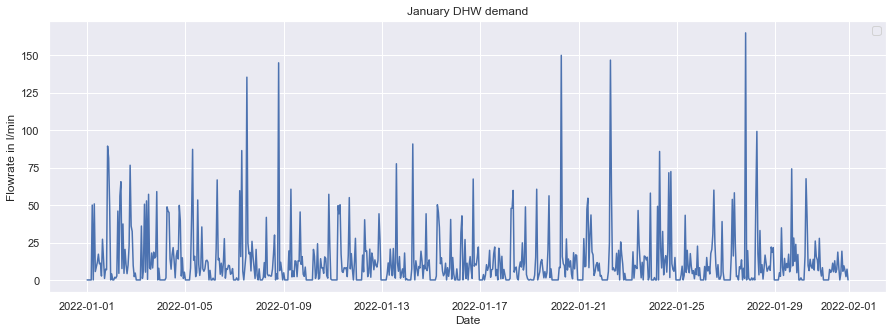

In [23]:
#Data Visualizations
from matplotlib import style

fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))
style.use('ggplot')

january=df.loc['20220101':'20220131']

sns.lineplot(data=january, x=january.index, y=january["Flowrate (l/min)"])
sns.set(rc={'figure.figsize':(15,5)})

plt.title("DHW demand")
plt.xlabel("Date")
plt.ylabel("Flowrate in l/min")
plt.grid(True)
plt.legend()


plt.title("January DHW demand")

In [24]:
#Feature Engineering for Time

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

df["Hour_of_day"] = df.index.hour
df['day_of_week'] = df.index.dayofweek

df["hour_sin"] = sin_transformer(24).fit_transform(df)["Hour_of_day"]
df["hour_cos"] = cos_transformer(24).fit_transform(df)["Hour_of_day"]
df.head(30)

,Flowrate (l/min),Hour_of_day,day_of_week,hour_sin,hour_cos
Time,,,,,
2022-01-01 00:00:00,0.0,0,5,0.000000e+00,1.000000e+00
2022-01-01 01:00:00,0.0,1,5,2.588190e-01,9.659258e-01
2022-01-01 02:00:00,0.0,2,5,5.000000e-01,8.660254e-01
2022-01-01 03:00:00,0.0,3,5,7.071068e-01,7.071068e-01
2022-01-01 04:00:00,0.0,4,5,8.660254e-01,5.000000e-01
2022-01-01 05:00:00,50.0,5,5,9.659258e-01,2.588190e-01
2022-01-01 06:00:00,0.0,6,5,1.000000e+00,6.123234e-17
2022-01-01 07:00:00,50.8,7,5,9.659258e-01,-2.588190e-01
2022-01-01 08:00:00,5.6,8,5,8.660254e-01,-5.000000e-01


In [25]:
#new dataframe for LSTM
df = df[['hour_sin', 'hour_cos', 'Flowrate (l/min)','day_of_week']]
#weekdays = 0, weekend = 1
df['day_of_week'] = df['day_of_week'].replace([0,1,2,3,4,5,6],[0,0,0,0,0,1,1])
df

,hour_sin,hour_cos,Flowrate (l/min),day_of_week
Time,,,,
2022-01-01 00:00:00,0.000000,1.000000,0.0,1
2022-01-01 01:00:00,0.258819,0.965926,0.0,1
2022-01-01 02:00:00,0.500000,0.866025,0.0,1
2022-01-01 03:00:00,0.707107,0.707107,0.0,1
2022-01-01 04:00:00,0.866025,0.500000,0.0,1
...,...,...,...,...
2022-12-31 19:00:00,-0.965926,0.258819,29.0,1
2022-12-31 20:00:00,-0.866025,0.500000,61.8,1
2022-12-31 21:00:00,-0.707107,0.707107,26.4,1


In [27]:
#Divide data
df_for_training=df[:7900]
df_for_test=df[7900:]

In [29]:
#window_size: number of hours to look back. Value of hour 169 will be based on previous 168 values (1week)
def df_to_X_y2(df, window_size=168):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][2]
    y.append(label)
  return np.array(X), np.array(y)
X_train,y_train=df_to_X_y2(df_for_training)
X_test, y_test=df_to_X_y2(df_for_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7732, 168, 4), (7732,), (692, 168, 4), (692,))

In [30]:
model =Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model.add(LSTM(units=64,return_sequences=True))
model.add(LSTM(units=32))
model.add(Dense(8))
model.add(Dense(1))    
model.compile(optimizer=Adam(), loss = MeanSquaredError(),metrics=[RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 128)          68096     
                                                                 
 lstm_1 (LSTM)               (None, 168, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 130,193
Trainable params: 130,193
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit(X_train,y_train,epochs=30,batch_size=16,validation_split=0.1)

Epoch 1/30
435/435 [==============================] - 47s 98ms/step - loss: 487.1586 - root_mean_squared_error: 22.0717 - val_loss: 531.6713 - val_root_mean_squared_error: 23.0580
Epoch 2/30
435/435 [==============================] - 40s 92ms/step - loss: 445.8225 - root_mean_squared_error: 21.1145 - val_loss: 476.9806 - val_root_mean_squared_error: 21.8399
Epoch 3/30
435/435 [==============================] - 40s 92ms/step - loss: 438.8079 - root_mean_squared_error: 20.9477 - val_loss: 488.8034 - val_root_mean_squared_error: 22.1089
Epoch 4/30
435/435 [==============================] - 40s 92ms/step - loss: 422.5508 - root_mean_squared_error: 20.5560 - val_loss: 467.0657 - val_root_mean_squared_error: 21.6117
Epoch 5/30
435/435 [==============================] - 40s 92ms/step - loss: 415.6968 - root_mean_squared_error: 20.3886 - val_loss: 465.8839 - val_root_mean_squared_error: 21.5843
Epoch 6/30
435/435 [==============================] - 40s 92ms/step - loss: 412.4951 - root_mean_squ

242/242 [==============================] - 11s 45ms/step


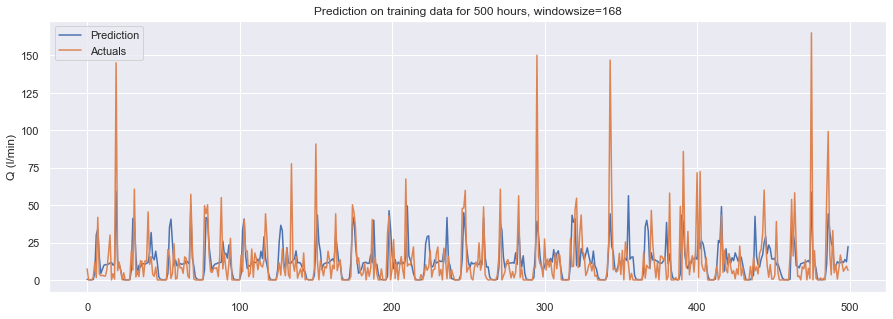

22/22 [==============================] - 1s 42ms/step


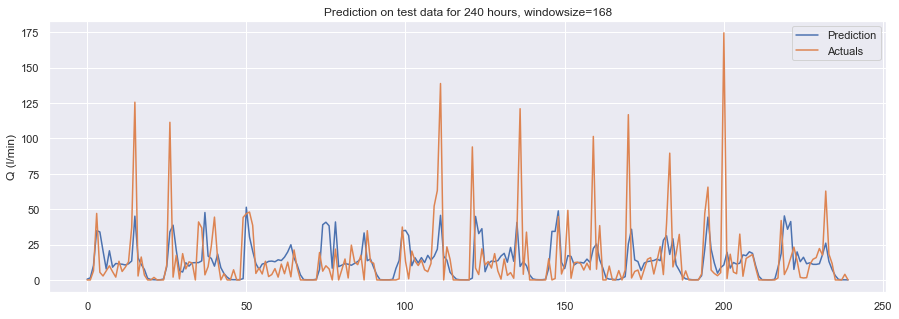

(     Predictions  Actuals
 0       0.544059      0.0
 1       1.476969      0.0
 2      10.207796      6.4
 3      34.866390     47.0
 4      33.928474      5.4
 ..           ...      ...
 687    34.531727     29.0
 688    14.085080     61.8
 689    12.989539     26.4
 690     6.455964      4.2
 691     3.461209      0.0
 
 [692 rows x 2 columns],
 430.6452708202069,
 array([ 0.54405886,  1.4769688 , 10.207796  , 34.86639   , 33.928474  ,
        20.501469  ,  7.7372317 , 20.625141  ,  9.015092  , 11.632866  ,
        11.2963295 , 11.121595  , 10.568928  , 11.401912  , 13.389394  ,
        45.075413  , 15.641919  , 10.929562  ,  7.373833  ,  1.1657274 ,
         0.32387656,  0.15259835,  0.10670176,  0.17618252,  0.61869144,
         9.264144  , 34.001926  , 38.683643  , 21.0267    ,  6.5151978 ,
         5.5903144 , 12.161401  ,  9.75217   , 12.1231    , 12.234659  ,
        12.257642  , 13.477223  , 47.652775  , 16.849604  , 15.200891  ,
         9.743644  , 18.3058    ,  8.700881  

In [33]:
from sklearn.metrics import mean_squared_error as mse
def plot_predictions1(model, X, y, start=0, end=500):
  predictions = model.predict(X).flatten()
  df1 = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df1['Predictions'][start:end])
  plt.plot(df1['Actuals'][start:end])
  plt.gca().legend(('Prediction','Actuals'))
  plt.ylabel('Q (l/min)')
  plt.show()
  return df1, mse(y, predictions),predictions
#validation
#df1=sc.transform(df1)
plt.title('Prediction on training data for 500 hours, windowsize=168')
plot_predictions1(model, X_train, y_train,0,500)

plt.title('Prediction on test data for 240 hours, windowsize=168')
plot_predictions1(model, X_test, y_test,0,240)